# Load data and plot

An example of how to load data quickly so it can be transformed into other forms etc.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import glob
import os.path
from multiprocessing import Pool

import matplotlib.pyplot as plt
import scmdata
import seaborn as sns
import tqdm.autonotebook as tqdman

<ipython-input-2-4057e79c21ce>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

In [3]:
plt.rcParams["figure.figsize"] = (12, 8)

<IPython.core.display.Javascript object>

In [4]:
STITCHED_DIR = "./country-crunch-stitched"
# STITCHED_NORMALISED_DIR = "./country-crunch-stitched-normalised"
MAX_WORKERS = 60

<IPython.core.display.Javascript object>

In [5]:
load_dir = STITCHED_DIR
# load_dir = STITCHED_NORMALISED_DIR

<IPython.core.display.Javascript object>

In [6]:
crunched_files = [
    f
    for f in glob.glob(os.path.join(load_dir, "**", "*.nc"), recursive=True)
    if "ssp" in f
]
crunched_files[:2]
crunched_files

['./country-crunch-stitched/netcdf-scm_tas_Amon_CanESM5_ssp245_r1i1p1f1_gn_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_CESM2-WACCM_ssp585_r4i1p1f1_gn_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_CESM2-WACCM_ssp126_r1i1p1f1_gn_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_NESM3_ssp245_r1i1p1f1_gn_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_IPSL-CM6A-LR_ssp460_r2i1p1f1_gr_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_CanESM5_ssp119_r10i1p1f1_gn_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_EC-Earth3-Veg_ssp119_r1i1p1f1_gr_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_CanESM5_ssp370_r1i1p1f1_gn_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_CanESM5_ssp245_r3i1p1f1_gn_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_CanESM5_ssp534-over_r1i1p1f1_gn_185001-230012.nc',
 './country-crunch-stitched/netcdf-sc

<IPython.core.display.Javascript object>

In [7]:
[f for f in crunched_files if "MRI-ESM2-0" in f]

['./country-crunch-stitched/netcdf-scm_tas_Amon_MRI-ESM2-0_ssp370-lowNTCF_r1i1p1f1_gn_185001-205512.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_MRI-ESM2-0_ssp370_r4i1p1f1_gn_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_MRI-ESM2-0_ssp585_r1i1p1f1_gn_185001-230012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_MRI-ESM2-0_ssp370-lowNTCF_r3i1p1f1_gn_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_MRI-ESM2-0_ssp370_r2i1p1f1_gn_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_MRI-ESM2-0_ssp126_r1i1p1f1_gn_185001-230012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_MRI-ESM2-0_ssp534-over_r1i1p1f1_gn_185001-230012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_MRI-ESM2-0_ssp119_r1i1p1f1_gn_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_MRI-ESM2-0_ssp245_r1i1p1f1_gn_185001-210012.nc',
 './country-crunch-stitched/netcdf-scm_tas_Amon_MRI-ESM2-0_ssp370-lowNTCF_r1i1p1f1_gn_185001-210012.nc',
 

<IPython.core.display.Javascript object>

In [8]:
dud_files = [
    "{}/netcdf-scm_tas_Amon_MRI-ESM2-0_ssp370-lowNTCF_r1i1p1f1_gn_185001-205512.nc".format(
        load_dir
    )
]
crunched_files = [f for f in crunched_files if f not in dud_files]

<IPython.core.display.Javascript object>

In [9]:
def load_file(f):
    return scmdata.ScmRun.from_nc(f)


all_dat = []
with Pool(MAX_WORKERS) as pool:
    all_dat = pool.map(load_file, crunched_files)

all_dat = scmdata.run_append(
    [scmdata.ScmRun(s.timeseries(time_axis="year-month")) for s in tqdman.tqdm(all_dat)]
)
# all_dat is an ScmRun object, might be useful
# alternately, the below gives you a pandas dataframe
all_dat_df = all_dat.timeseries()
all_dat_df

/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_variable(ds.variables["time"])
/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_variable(ds.variables["time"])
/data/ubuntu-znicholls/miniconda3/envs/cmip6-country-level-processing/lib/python3.8/site-packages/scmdata/netcdf.py:201: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dims["time"] = _read_time_varia

  0%|          | 0/429 [00:00<?, ?it/s]

time                                                                                                                                            1850-01-16 05:00:00  \
activity_id climate_model grid member_id mip_era model       region                              scenario unit variable variable_standard_name                        
ScenarioMIP CanESM5       gn   r1i1p1f1  CMIP6   unspecified World                               ssp245   K    tas      air_temperature                  284.967101   
                                                             World|Natural Earth 50m|Afghanistan ssp245   K    tas      air_temperature                  265.308965   
                                                             World|Natural Earth 50m|Algeria     ssp245   K    tas      air_temperature                  281.206969   
                                                             World|Natural Earth 50m|Angola      ssp245   K    tas      air_temperature                  295.065311   
                                                             World|Natural Earth 50m|Antarctica  ssp245   K    tas      air_temperature                  250.958276   
...                                                                                                                                                             ...   
            NorESM2-LM    gn   r1i1p1f1  CMIP6   unspecified World|Natural Earth 50m|Vietnam     ssp126   K    tas      air_temperature                  290.518624   
                                                             World|Natural Earth 50m|W. Sahara   ssp126   K    tas      air_temperature                  289.718506   
                                                             World|Natural Earth 50m|Yemen       ssp126   K    tas      air_temperature                  294.137008   
                                                             World|Natural Earth 50m|Zambia      ssp126   K    tas      air_temperature                  296.673406   
                                                             World|Natural Earth 50m|Zimbabwe    ssp126   K    tas      air_temperature                  298.363122   

time                                                                                                                                            1850-02-15 15:00:00  \
activity_id climate_model grid member_id mip_era model       region                              scenario unit variable variable_standard_name                        
ScenarioMIP CanESM5       gn   r1i1p1f1  CMIP6   unspecified World                               ssp245   K    tas      air_temperature                  284.944084   
                                                             World|Natural Earth 50m|Afghanistan ssp245   K    tas      air_temperature                  263.902015   
                                                             World|Natural Earth 50m|Algeria     ssp245   K    tas      air_temperature                  284.020036   
                                                             World|Natural Earth 50m|Angola      ssp245   K    tas      air_temperature                  295.511265   
                                                             World|Natural Earth 50m|Antarctica  ssp245   K    tas      air_temperature                  243.305721   
...                                                                                                                                                             ...   
            NorESM2-LM    gn   r1i1p1f1  CMIP6   unspecified World|Natural Earth 50m|Vietnam     ssp126   K    tas      air_temperature                  293.962389   
                                                             World|Natural Earth 50m|W. Sahara   ssp126   K    tas      air_temperature                  291.514954   
                                                             World|Natural Earth 50m|Yemen       ssp126   K    tas      air_temperature                  293.8

<IPython.core.display.Javascript object>

In [10]:
cms = all_dat.get_unique_meta("climate_model")
display(len(cms))
sorted(cms)

44

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CAS-ESM2-0',
 'CESM2',
 'CESM2-WACCM',
 'CIESM',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'E3SM-1-1',
 'EC-Earth3',
 'EC-Earth3-CC',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'GISS-E2-1-G',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'IITM-ESM',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'KIOST-ESM',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL']

<IPython.core.display.Javascript object>

In [11]:
print("\n".join(sorted(cms)))

ACCESS-CM2
ACCESS-ESM1-5
AWI-CM-1-1-MR
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
CESM2
CESM2-WACCM
CIESM
CMCC-CM2-SR5
CMCC-ESM2
CNRM-CM6-1
CNRM-CM6-1-HR
CNRM-ESM2-1
CanESM5
CanESM5-CanOE
E3SM-1-1
EC-Earth3
EC-Earth3-CC
EC-Earth3-Veg
EC-Earth3-Veg-LR
FGOALS-f3-L
FGOALS-g3
GISS-E2-1-G
HadGEM3-GC31-LL
HadGEM3-GC31-MM
IITM-ESM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
KIOST-ESM
MIROC-ES2L
MIROC6
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorESM2-LM
NorESM2-MM
TaiESM1
UKESM1-0-LL


<IPython.core.display.Javascript object>

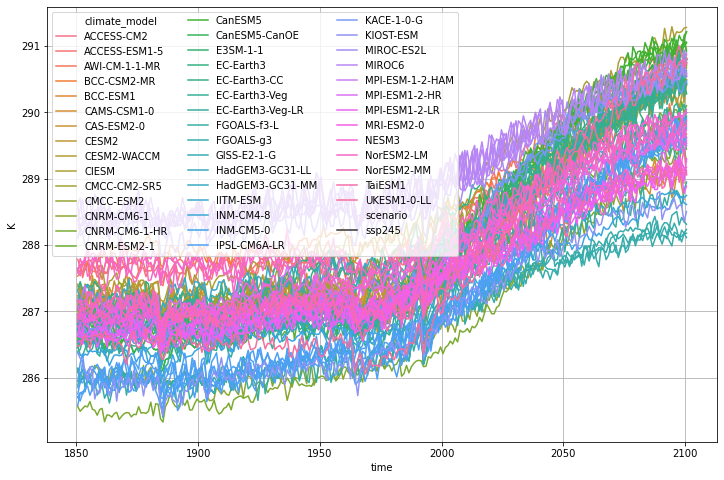

<IPython.core.display.Javascript object>

In [12]:
ax = (
    all_dat.time_mean("AC").filter(region="*World")  # , year=range(2010, 2020 + 1))
    #     .filter(scenario=["ssp119", "ssp126", "ssp245"])
    .filter(scenario="ssp245")
    #     .filter(climate_model="FIO*")
    .lineplot(
        style="scenario",
        hue="climate_model",
        hue_order=sorted(cms),
        units="member_id",
        estimator=None,
        time_axis="year-month",
    )
)
ax.legend(loc="upper left", ncol=3)
ax.grid()
# ax.axvline(2014.5)

In [13]:
mean_years = range(2081, 2100 + 1)
# mean_years = range(2021, 2040 + 1)
val_col = "{}-{} mean".format(mean_years[0], mean_years[-1])
bardf = (
    all_dat.filter(year=mean_years)
    .time_mean("AC")
    .timeseries(time_axis="year")
    .mean(axis="columns")
    .reset_index()
    .rename({0: val_col}, axis="columns")
)
bardf

,activity_id,climate_model,grid,member_id,mip_era,model,region,scenario,unit,variable,variable_standard_name,2081-2100 mean
0,ScenarioMIP,CanESM5,gn,r1i1p1f1,CMIP6,unspecified,World,ssp245,K,tas,air_temperature,290.880890
1,ScenarioMIP,CanESM5,gn,r1i1p1f1,CMIP6,unspecified,World|Natural Earth 50m|Afghanistan,ssp245,K,tas,air_temperature,287.730572
2,ScenarioMIP,CanESM5,gn,r1i1p1f1,CMIP6,unspecified,World|Natural Earth 50m|Algeria,ssp245,K,tas,air_temperature,298.799341
3,ScenarioMIP,CanESM5,gn,r1i1p1f1,CMIP6,unspecified,World|Natural Earth 50m|Angola,ssp245,K,tas,air_temperature,300.155954
4,ScenarioMIP,CanESM5,gn,r1i1p1f1,CMIP6,unspecified,World|Natural Earth 50m|Antarctica,ssp245,K,tas,air_temperature,240.483813
...,...,...,...,...,...,...,...,...,...,...,...,...
64308,ScenarioMIP,NorESM2-LM,gn,r1i1p1f1,CMIP6,unspecified,World|Natural Earth 50m|Vietnam,ssp126,K,tas,air_temperature,298.635554
64309,ScenarioMIP,NorESM2-LM,gn,r1i1p1f1,CMIP6,unspecified,World|Natural Earth 50m|W. Sahara,ssp126,K,tas,air_temperature,301.477363
64310,ScenarioMIP,NorESM2-LM,gn,r1i1p1f1,CMIP6,unspecified,World|Natural Earth 50m|Yemen,ssp126,K,tas,air_temperature,301.222091
64311,ScenarioMIP,NorESM2-LM,gn,r1i1p1f1,CMIP6,unspecified,World|Natural Earth 50m|Zambia,ssp126,K,tas,air_temperature,296.417347


<IPython.core.display.Javascript object>

In [14]:
tmp = bardf[bardf["region"] == "World"][["scenario", "climate_model"]].drop_duplicates()
tmp["scenario"].value_counts()

ssp585            42
ssp245            41
ssp126            40
ssp370            37
ssp119            13
ssp434             8
ssp460             7
ssp534-over        7
ssp370-lowNTCF     6
Name: scenario, dtype: int64

<IPython.core.display.Javascript object>

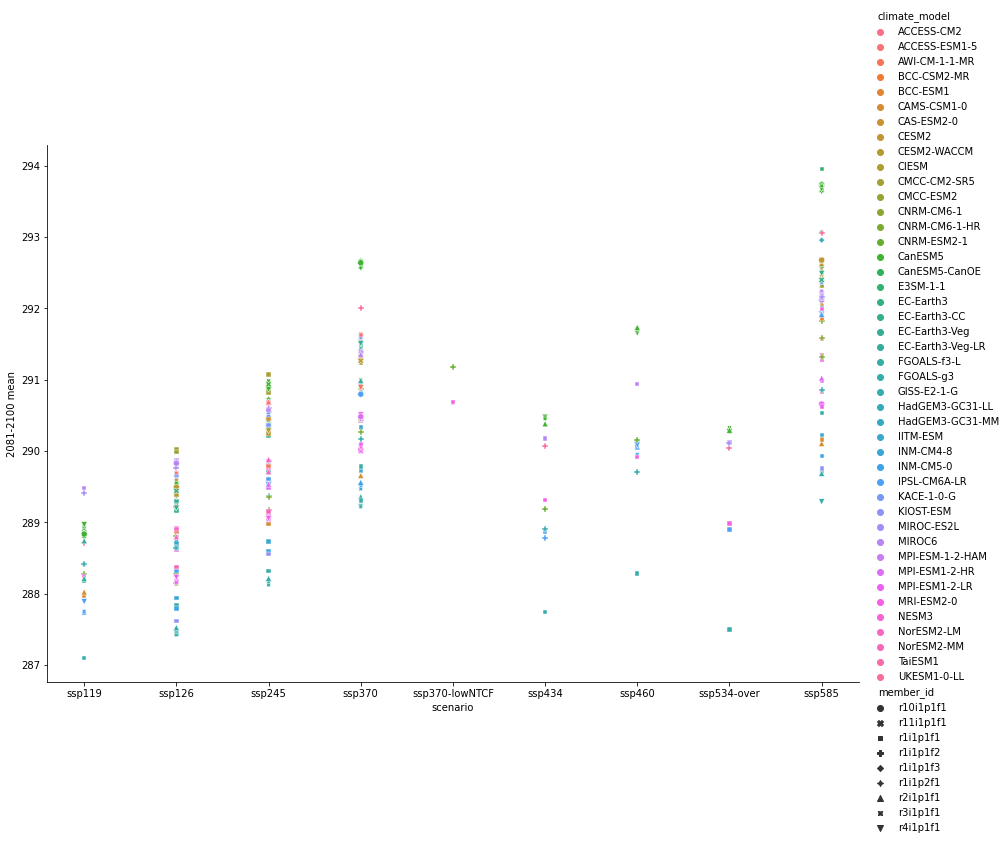

<IPython.core.display.Javascript object>

In [15]:
sns.relplot(
    data=bardf[bardf["region"] == "World"].sort_values(by="scenario"),
    #     x="climate_model",
    #     y="value",
    #     hue="scenario",
    x="scenario",
    y=val_col,
    hue="climate_model",
    hue_order=sorted(bardf["climate_model"].unique().tolist()),
    style="member_id",
    style_order=sorted(bardf["member_id"].unique().tolist()),
    #     estimator="median",
    height=8,
    aspect=1.5,
    #     kind="line",
    #     marker="x",
)